# **Import Modules**

In [1]:
import sys, os, copy, glob
import random as pyrand

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sys.path.insert(0, '../input/kerasstylegan/')

In [2]:
from externals.io import TFRecordReader
from stylegan import gan, functional, processing

# from stylegan.callbacks import LearningRateScheduler

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [4]:
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets

In [5]:
import tensorflow as tf
from tensorflow.keras import backend, optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint

# **Config**

In [6]:
print(tf.__version__)

2.6.3


In [7]:
tqdm.pandas()

In [8]:
class Config:
    
    experiment_id = 0
    
    seed = 1265
        
    low_resolution = 4
    resolution = 256
    num_clusters = 1
    
    use_crop = False
    use_pseudo_labels = False
    
    crop_resolution = 128

    batch_size = 4
    
    epochs = 5

In [9]:
strategy = tf.distribute.get_strategy()

Config.num_replicas = strategy.num_replicas_in_sync

print('REPLICAS: ', Config.num_replicas)

REPLICAS:  1


In [10]:
def set_seed(tf_seed=Config.seed, np_seed=Config.seed, py_rand=Config.seed, py_hash=Config.seed):

    os.environ['PYTHONHASHSEED'] = str(py_hash)
    pyrand.seed(py_rand)

    tf.random.set_seed(tf_seed)
    np.random.seed(np_seed)

In [11]:
set_seed()

In [12]:
augmenter = []

if Config.use_crop:

    random_crop = [
        preprocessing.RandomCrop(height=Config.crop_resolution, width=Config.crop_resolution), 
        preprocessing.Resizing(height=Config.resolution, width=Config.resolution, interpolation='bilinear', crop_to_aspect_ratio=False)
    ]
    
    random_crop =  Sequential(random_crop)
    random_crop.build((None, Config.resolution, Config.resolution, 3))
        
augmenter.append(preprocessing.RandomFlip('horizontal'))
augmenter.append(preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, interpolation='nearest'))
augmenter.append(preprocessing.RandomRotation(factor=0.2))
augmenter.append(preprocessing.RandomZoom(height_factor=(-0.3, 0.2), width_factor=(-0.3, 0.2)))

augmenter = Sequential(augmenter)
augmenter.build((None, Config.resolution, Config.resolution, 3))

In [13]:
filename = f'data{Config.resolution}x{Config.resolution}'

working_dir = f'../input/celeba-hq/celebaHQ/{filename}/{filename}'

image_path = glob.glob(working_dir + '/*')

print(len(image_path))

30000


# **Utils**

In [14]:
@tf.function
def read_fn(path):
    
    raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(raw, channels=3)
        
    return image

In [15]:
def normalize(images):
    
    images = tf.clip_by_value(images, clip_value_min=0.0, clip_value_max=255.0)
    images = (images - 127.5) / 127.5
    
    return images

def denormalize(images):
    
    images = (images * 127.5) + 127.5
    images = tf.clip_by_value(images, clip_value_min=0.0, clip_value_max=255.0)

    return images

In [16]:
def show_images(images, n=5, seed=Config.seed):
        
    random = np.random.RandomState(seed=seed)
    
    indices = np.arange(len(images))
    indices = random.choice(indices, size=n*n, replace=False)
    
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(15, 15))
    axs = axs.flatten()
    
    for i, idx in enumerate(indices):
        
        axs[i].imshow(images[idx])
        axs[i].axis('off')
    
    fig.tight_layout()
    fig.show()

In [17]:
def scheduler(steps, scale_fn):
    
    def _scheduler(epoch, lr):
        
        if epoch > 0 and epoch % steps == 0:
            
            return max(1e-8, scale_fn(lr))
        
        else:
            
            return max(1e-8, lr)
    
    return _scheduler

In [18]:
def checkpoint(path):
    
    callback = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
    
    return callback

# **Load Data**

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

options = tf.data.Options()
options.experimental_deterministic = False

In [20]:
def batch_preprocessing(add_noise):
    
    def _preprocessing(images):

        batch_size = tf.shape(images)[0]

        images = tf.cast(images, dtype=tf.float32)
        images = normalize(images)
        
        if Config.use_crop and (processing.random_uniform_state(precision=2) < 0.1):
            
            images = random_crop(images, training=True)
            
        if Config.use_pseudo_labels:
            
            labels = processing.sample_pseudo_labels(size=batch_size, num_classes=Config.num_clusters)
            
        else:
            
            labels = processing.sample_adversarial_labels(size=batch_size, num_classes=Config.num_clusters)
        
        if add_noise:
            
            images += tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1.0)
            
        return images, labels
    
    return _preprocessing

In [21]:
def get_celeba_dataset_generator(filenames, batch_size=32, add_noise=False):

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.shuffle(2 * len(filenames), reshuffle_each_iteration=True)
    dataset = dataset.with_options(options)
    dataset = dataset.map(read_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(batch_preprocessing(add_noise), num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

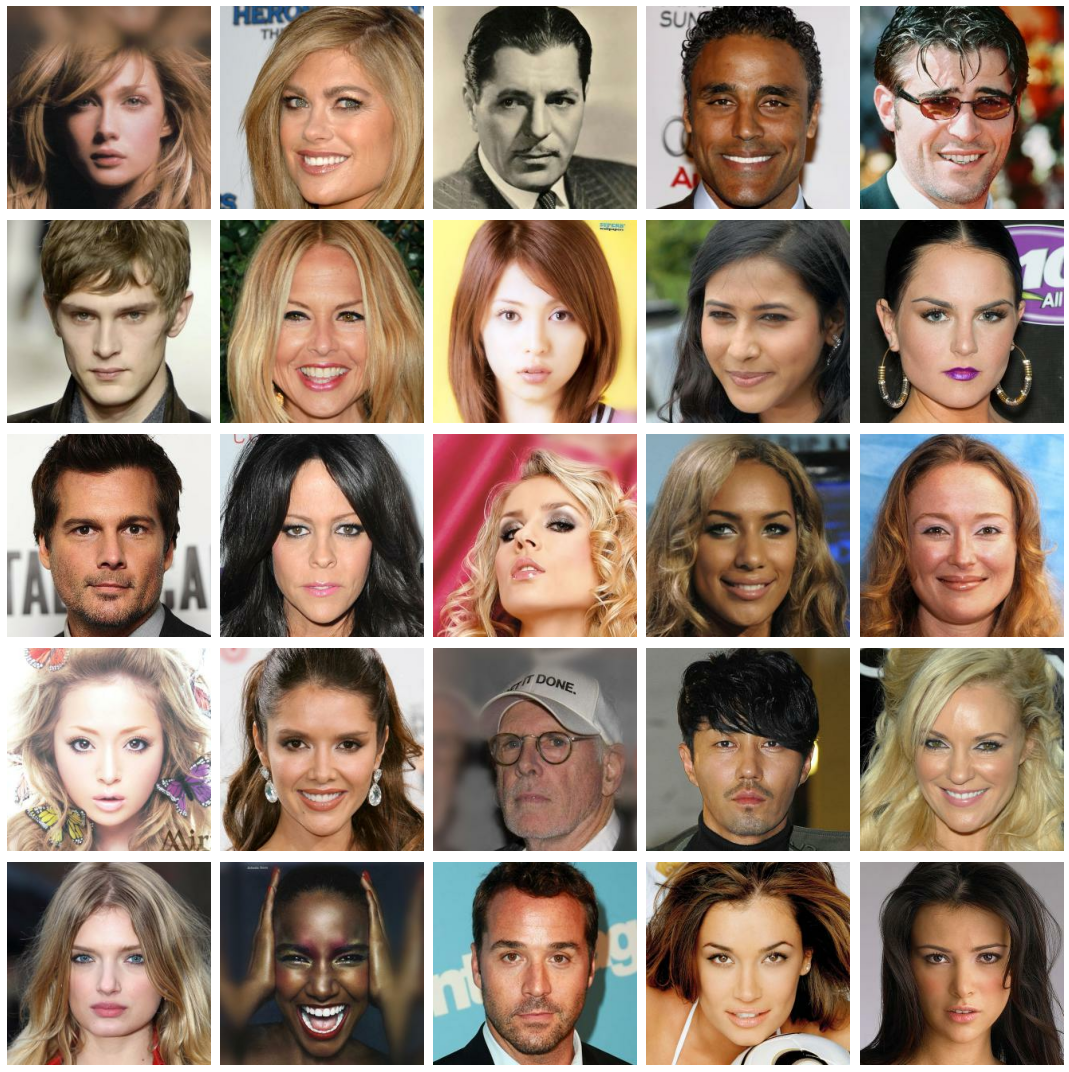

In [22]:
sample_dataset = get_celeba_dataset_generator(image_path, batch_size=25)

sample_x, sample_y = sample_dataset.as_numpy_iterator().next()

show_images(denormalize(sample_x) / 255.0)

# **Build Model**

In [24]:
def generator_wgan_loss(*args, **kwargs):
    
    loss = functional.generator_wgan_loss(*args, **kwargs)
    
    return loss

def discriminator_wgan_loss(*args, **kwargs):
    
    loss = functional.discriminator_wgan_loss(*args, **kwargs)
    
    return loss

def wgan_gradient_penalty(*args, **kwargs):
    
    loss = functional.wgan_gradient_penalty(*args, **kwargs)
    
    return loss

In [26]:
set_seed()

mapping_cfgs = {'latent_dim': 256, 'disentangled_latent_dim': 256, 'num_clusters': None,
                'depth': 4, 'learning_rate_multiplier': 0.01}

synthesis_cfgs = {'resolution': Config.resolution, 'low_resolution': Config.low_resolution, 'constant_input_dim': 256,
                  'in_filters': 8192, 'in_decay': 1.0, 'use_skip': True, 'fused': True, 'learning_rate_multiplier': 1.0}

discriminator_cfgs = {'resolution': Config.resolution, 'low_resolution': Config.low_resolution, 'num_clusters': Config.num_clusters, 
                      'in_filters': 4096, 'in_decay': 1.0, 'use_skip': True, 'learning_rate_multiplier': 1.0}

with strategy.scope():
        
    model = gan.build_stylegan(mapping_cfgs=mapping_cfgs, synthesis_cfgs=synthesis_cfgs, discriminator_cfgs=discriminator_cfgs, 
                               batch_size=None, use_pseudo_labels=Config.use_pseudo_labels, augmenter=augmenter, 
                               ada_target=1.0, ada_step=25, recursive_lookup=True)

    generator_loss = generator_wgan_loss
    discriminator_loss = discriminator_wgan_loss
    gradient_penalty = wgan_gradient_penalty
    
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
    
    model.compile(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
                  generator_loss=generator_loss, discriminator_loss=discriminator_loss, gradient_penalty=gradient_penalty, 
                  clip_min=None, clip_max=None, use_clip=False, run_eagerly=False)
    
    model.load_weights('../input/stylegan-celebahq-weights-v0/stylegan-celebA-HQ-0.h5')
        
# model.summary()

In [27]:
# model.get_layer('ada').reset()

# **Training**

In [28]:
dataset = get_celeba_dataset_generator(image_path, batch_size=Config.batch_size)

In [29]:
backend.clear_session()

experiment_id = Config.experiment_id

In [39]:
callbacks = None

# callbacks = []
# callbacks.append(checkpoint(f'stylegan-celebA-HQ-{experiment_id}.h5'))

model.fit(dataset, epochs=Config.epochs, callbacks=callbacks)

In [40]:
model.save_weights(f'stylegan-celebA-HQ-{experiment_id}.h5')

# **Sample Debugging**

In [41]:
set_seed()

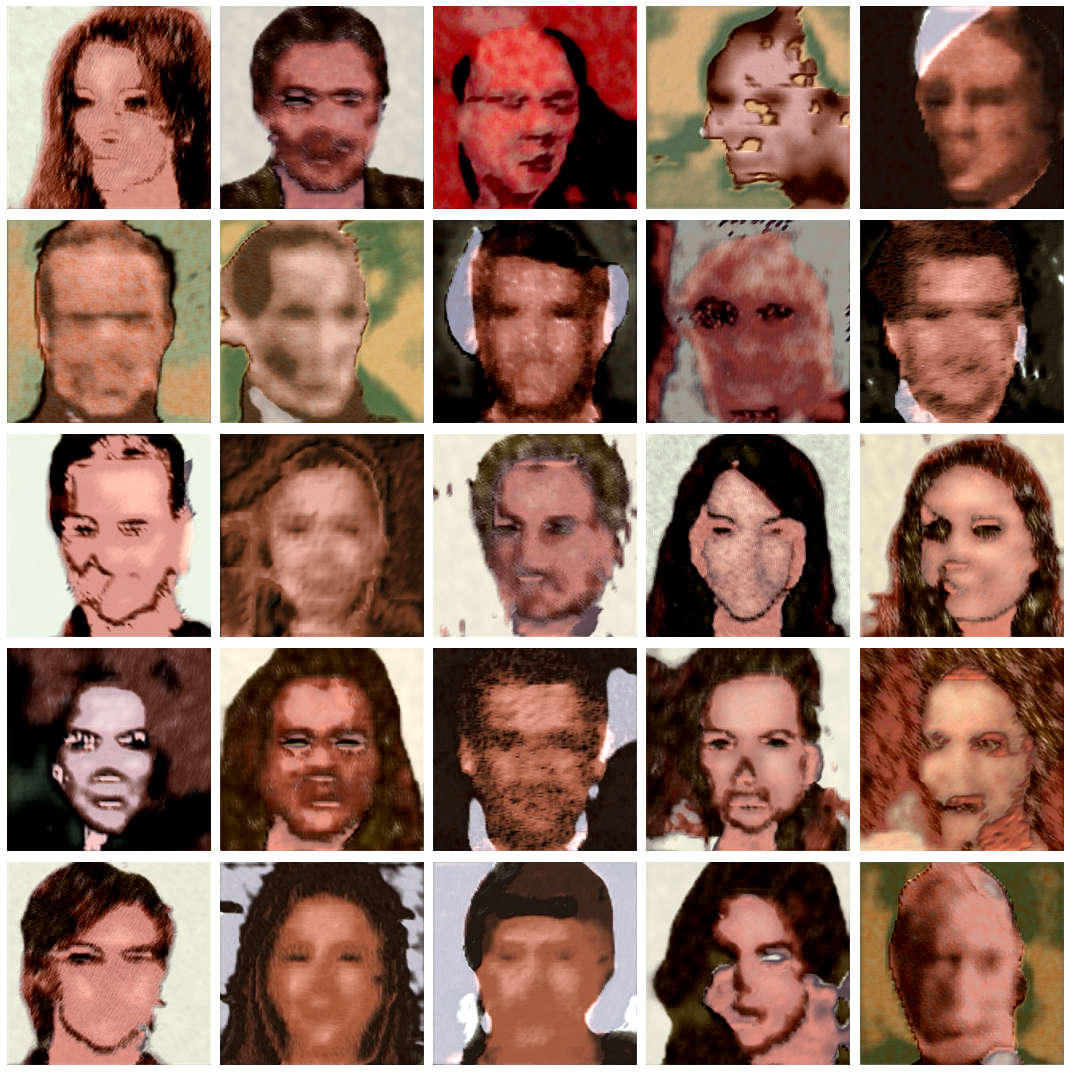

In [42]:
sample_latent = model.sample_latent(size=25)

sample_gen = model([sample_latent], training=True)

show_images(denormalize(sample_gen) / 255.0)

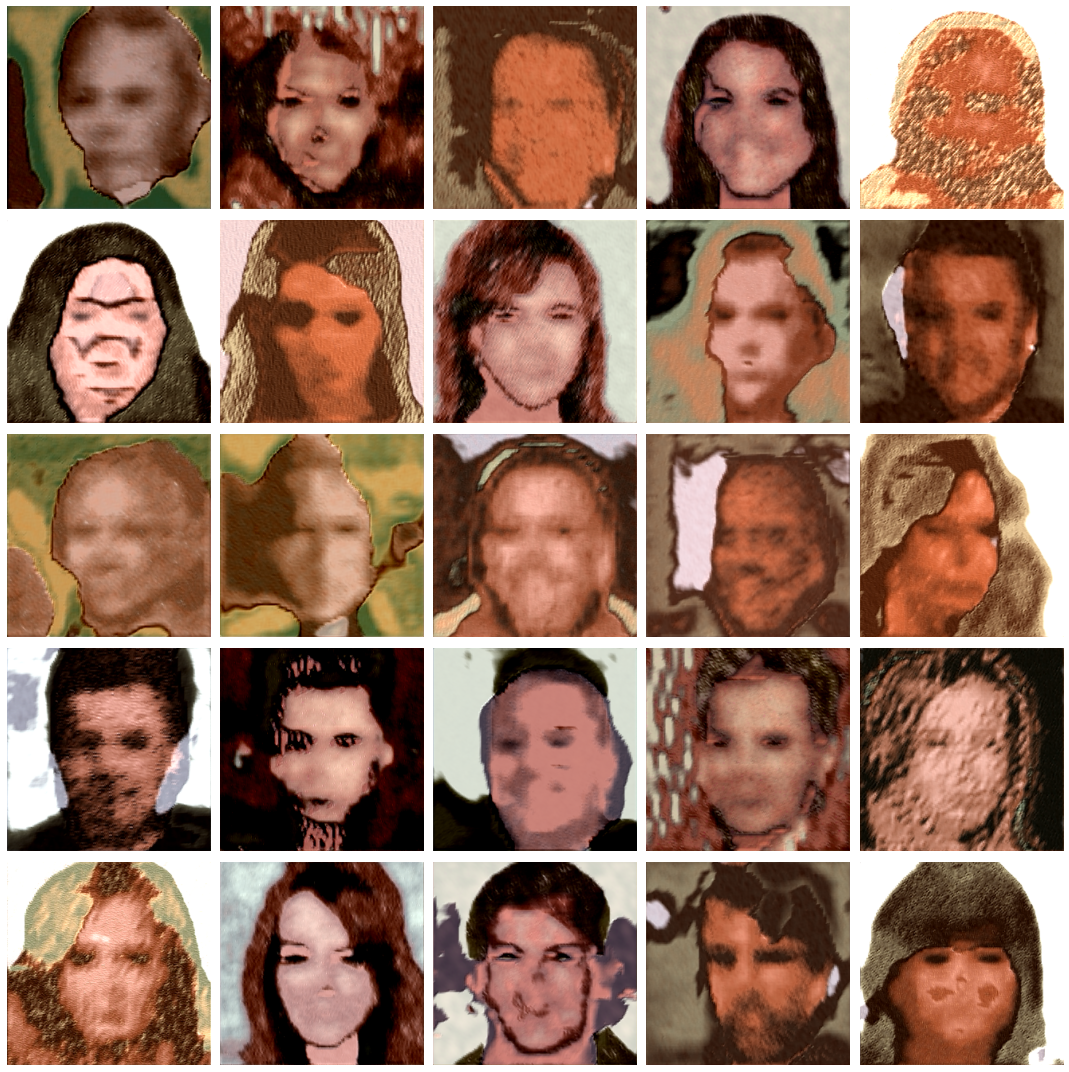

In [43]:
sample_latent = model.sample_latent(size=25)

sample_gen = model([sample_latent], training=True)

show_images(denormalize(sample_gen) / 255.0)

In [44]:
for layer in model.generator.layers:
    
    if 'noise' in layer.name:
        
        print(tf.math.reduce_min(layer.strength), tf.math.reduce_max(layer.strength))

tf.Tensor(-0.19460742, shape=(), dtype=float32) tf.Tensor(0.21519072, shape=(), dtype=float32)
tf.Tensor(-0.6183083, shape=(), dtype=float32) tf.Tensor(0.7991005, shape=(), dtype=float32)
tf.Tensor(-0.07564522, shape=(), dtype=float32) tf.Tensor(0.12999968, shape=(), dtype=float32)
tf.Tensor(-1.7205983, shape=(), dtype=float32) tf.Tensor(2.1859078, shape=(), dtype=float32)
tf.Tensor(-0.23123156, shape=(), dtype=float32) tf.Tensor(0.29990548, shape=(), dtype=float32)
tf.Tensor(-10.27111, shape=(), dtype=float32) tf.Tensor(4.3651776, shape=(), dtype=float32)
tf.Tensor(-0.11371936, shape=(), dtype=float32) tf.Tensor(0.09869582, shape=(), dtype=float32)
tf.Tensor(-13.226818, shape=(), dtype=float32) tf.Tensor(17.69492, shape=(), dtype=float32)
tf.Tensor(-0.119349375, shape=(), dtype=float32) tf.Tensor(0.14140622, shape=(), dtype=float32)
tf.Tensor(-18.057272, shape=(), dtype=float32) tf.Tensor(8.988608, shape=(), dtype=float32)
tf.Tensor(-0.072764486, shape=(), dtype=float32) tf.Tensor(0.0